In [443]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from fancyimpute import MICE
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [510]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [453]:
with open('./data/raw/user_subset.pkl', 'rb') as picklefile:
    user = pickle.load(picklefile)
with open('./data/raw/session_subset.pkl', 'rb') as picklefile:
    session = pickle.load(picklefile)

## Format and split user data

In [454]:
# Impute the missing action_type and action_details with mode values
def impute_mode(df, col_key, col_na, mode_table=None):
    
    if (mode_table == None):
        mode_series = df[~df[col_na].isna()].groupby(col_key)[col_na].agg(lambda x:x.value_counts().index[0])
        mode_series = pd.DataFrame(mode_series.reset_index())
    else:
        mode_series = mode_table
    merged_frame = pd.merge(df, mode_series, how='left', 
                             left_on=[col_key], 
                             right_on=[col_key])
    
    merged_frame.rename(columns={col_na+'_x': col_na, col_na+'_y':'mode_value'}, inplace=True)
    merged_frame[col_na].fillna(merged_frame.mode_value, inplace=True)
    merged_frame.drop(['mode_value'], axis=1, inplace=True)
    
    return merged_frame, mode_table

In [455]:
def date_transformation(user):
    user['date_account_created'] = pd.to_datetime(user['date_account_created'], format='%Y-%m-%d')
    user['timestamp_first_active'] = pd.to_datetime(user['timestamp_first_active']//1000000, format='%Y%m%d')
    user.drop('date_first_booking', axis=1, inplace=True)
    user['account_age'] = user['date_account_created'].apply(lambda x:(x.year-1970)*12+x.month)
    user['active_age'] = user['timestamp_first_active'].apply(lambda x:(x.year-1970)*12+x.month)

In [457]:
user['account_age'] = user['date_account_created'].apply(lambda x:(x.year-1970)*12+x.month)
user['active_age'] = user['timestamp_first_active'].apply(lambda x:(x.year-1970)*12+x.month)

In [458]:
y_user = pd.DataFrame(user['country_destination'].values, columns=['country_destination'], index=user.id)
X_user = user.drop(['country_destination'], axis=1)
X_user.set_index('id', drop=False, inplace=True);

In [248]:
y_user.head()

,country_destination
id,
6fsk4w7bya,US
atws2zzacv,NDF
tleefrh3ox,NDF
8b0lo9judh,CA
nwjtkv07ef,NDF


In [488]:
X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(X_user, y_user, test_size = 0.25, random_state=1234, stratify=y_user)

In [250]:
with open('./data/processed/X_user_train.pkl', 'wb') as picklefile:
    pickle.dump(X_user_train, picklefile)
with open('./data/processed/X_user_test.pkl', 'wb') as picklefile:
    pickle.dump(X_user_test, picklefile)
with open('./data/processed/y_user_train.pkl', 'wb') as picklefile:
    pickle.dump(y_user_train, picklefile)
with open('./data/processed/y_user_test.pkl', 'wb') as picklefile:
    pickle.dump(y_user_test, picklefile)

## Deal with wrong and missing values in user data

In [489]:
X_user_train.first_affiliate_tracked.fillna('catchall', inplace=True)
X_user_train.loc[((X_user_train['age'] <= 10) | (X_user_train['age'] >= 100)), 'age' ] = np.NAN
cols_to_drop = ['date_account_created', 'timestamp_first_active']
X_user_train.drop(cols_to_drop, axis=1, inplace=True)

Imput data with median value
median_age = X_user_train[~X_user_train['age'].isna()].age.median()
X_user_train.loc[X_user_train['age'].isna(), 'age'] = median_age

#X_user_train,_ = impute_mode(X_user_train, 'first_browser', 'age')

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [492]:
X_user_train.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_age,active_age
0,42crlcaola,FEMALE,45.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,512,512
1,8yt6tsq014,FEMALE,30.0,facebook,12,en,api,other,untracked,Web,Mac Desktop,Safari,507,507
2,n4d5bv979o,MALE,38.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,512,512
3,sdb6gntd23,-unknown-,27.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,532,532
4,lhjhtonq0j,MALE,59.0,facebook,0,en,direct,direct,linked,Web,Mac Desktop,Firefox,533,533


In [490]:
X_user_train.age.describe()

count    16000.000000
mean        33.550187
std          9.526484
min         16.000000
25%         28.000000
50%         30.000000
75%         35.000000
max         98.000000
Name: age, dtype: float64

In [491]:
X_user_test.age.describe()

count    3185.00000
mean       48.59686
std       148.82806
min        17.00000
25%        28.00000
50%        34.00000
75%        43.00000
max      2014.00000
Name: age, dtype: float64

In [465]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude='object')
    # print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [493]:
X_user_train, user_train_cols = custom_dummify(X_user_train, 0.01)

## Split and deal with wrong and missing values in session data

In [262]:
session.set_index('user_id', drop=False, inplace=True)
train_index = list(X_user_train.index)
session_train = session[session['user_id'].isin(train_index)]
session_test = session[~session['user_id'].isin(train_index)]

In [263]:
with open('./data/processed/session_train.pkl', 'wb') as picklefile:
    pickle.dump(session_train, picklefile)
with open('./data/processed/session_test.pkl', 'wb') as picklefile:
    pickle.dump(session_test, picklefile)

In [267]:
np.sum(session_train.isna())

user_id              0
action               0
action_type      47976
action_detail    47976
device_type          0
secs_elapsed      5606
dtype: int64

In [266]:
# Replace NaN in action column with others
session_train['action'].fillna("catch-all", inplace=True)
# Clip the sessions longer than 24 hours to 24 hours
session_test.loc[session_test['secs_elapsed']>24*3600, 'secs_elapsed'] = 24*3600

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [396]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude='object')
    # print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [271]:
session_train, action_type_mode = impute_mode(session_train, 'action', 'action_type')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'action_detail')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'secs_elapsed')
session_train.fillna("catch-all", inplace=True)

In [353]:
df = session_train
cat_cols = list(df.select_dtypes(include='object').columns)[1:]

In [432]:
def get_session_cat_stats(user_df, session_df):
    session_stats = pd.DataFrame(index=user_df.index)
    cat_cols = list(session_df.select_dtypes(include='object').columns)[1:]
    
    for col in cat_cols:
        val_freq = Counter(session_df[col])
        sig_val = list(val_freq.keys())

        for val in sig_val:
            val_count = session_df.groupby(session_df.index).apply(lambda x, val=val, col=col: np.sum(x[col] == val))
            tmp = pd.DataFrame(val_count.values, columns=[col+'['+val+']'], index=val_count.index)
            session_stats = pd.merge(session_stats, tmp, how='left', left_index=True, right_index=True )
    return session_stats

In [357]:
session_stats = pd.DataFrame(index=X_user_train.index)

for col in cat_cols:
    val_freq = Counter(df[col])
    sig_val = list(val_freq.keys())
    
    for val in sig_val:
        val_count = df.groupby(df.index).apply(lambda x, val=val, col=col: np.sum(x[col] == val))
        tmp = pd.DataFrame(val_count.values, columns=[col+'['+val+']'], index=val_count.index)
        session_stats = pd.merge(session_stats, tmp, how='left', left_index=True, right_index=True )

In [358]:
with open('./data/processed/session_stats.pkl', 'wb') as picklefile:
    pickle.dump(session_stats, picklefile)

## Combine session and user data

In [494]:
session_stats.fillna(0.0, inplace=True)
X_user_train_1 = deepcopy(X_user_train)
X_user_train_1 = X_user_train_1.merge(session_stats, how='left', left_index=True, right_index=True)
session_sec_stats = df.groupby('user_id')['secs_elapsed'].agg([np.median, np.mean, np.std])
session_sec_stats.rename(columns={'median':'sess[median]', 'mean':'sess[mean]', 'std':'sess[std]'}, inplace=True)
X_user_train_1 = X_user_train_1.merge(session_sec_stats, how='left', left_index=True, right_index=True)
X_user_train_1.fillna(0.0, inplace=True)

In [449]:
session_stats.head(10)

,action_type[booking_request],action_type[view],action_type[message_post],action_type[data],action_type[click],action_type[catch-all],action_type[partner_callback],action_type[-unknown-],action_type[submit],action_detail[popular_wishlists],...,device_type[iPhone],device_type[iPad Tablet],device_type[Windows Phone],device_type[Android Phone],device_type[Linux Desktop],device_type[Mac Desktop],device_type[Windows Desktop],device_type[Android App Unknown Phone/Tablet],device_type[Tablet],device_type[-unknown-]
id,,,,,,,,,,,,,,,,,,,,,
42crlcaola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8yt6tsq014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n4d5bv979o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sdb6gntd23,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
lhjhtonq0j,0.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
f29qtd5lh6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9ib3wi5ebi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ge1185pcsr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
h54uenp3fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build a baseline model for NDF and Booking

In [468]:
y_bin = deepcopy(y_user_train)
y_bin['booking'] = 1 - (y_bin['country_destination'] == 'NDF').astype('int')
y_bin.drop(['country_destination'], axis=1, inplace=True)
y_train=y_bin

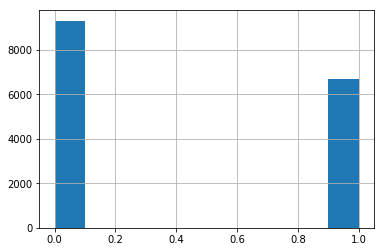

In [469]:
y_train['booking'].hist()

In [495]:
ssX = StandardScaler()
X_train_imputed_scaled = ssX.fit_transform(X_user_train_1)

In [499]:
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]


grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train_imputed_scaled, y_train)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids[name] = grid

tree: best score: 0.6948095553896777


**Result-Accuracy**<br>
knn: best score: 0.6414292853573214 <br>
logistic: best score: 0.6689780109945027 <br>
tree: best score: 0.698088455772114 <br>
forest: best score: 0.6454897551224388 <br>

**Result-AUC**<br>
knn: best score: 0.6797561404771426<br>
logistic: best score: 0.7137787331059189<br>
tree: best score: 0.7405620278725061<br>
forest: best score: 0.731510519720228<br>

Best model - tree <br>
    
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5, <br>
            max_features=None, max_leaf_nodes=None,<br>
            min_impurity_decrease=0.0, min_impurity_split=None,<br>
            min_samples_leaf=10, min_samples_split=2,<br>
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,<br>
            splitter='best')

## Try XGBOOST

In [500]:
from xgboost.sklearn import XGBClassifier

In [508]:
param = {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['binary:logistic']
    }

In [511]:
xgb = XGBClassifier(objective='binary:logitraw')
grid2 = GridSearchCV(xgb, param, scoring='roc_auc', cv=5, n_jobs=-1)
grid2.fit(X_train_imputed_scaled, y_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: 

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logitraw', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': array([0.001  , 0.00562, 0.03162, 0.17783, 1.     ]), 'max_depth': [3, 5, 7, 9], 'objective': ['binary:logistic'], 'n_estimators': [10, 50, 80, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [512]:
grid2.score(X_train_imputed_scaled, y_train)

0.7838892668350149

best parameters for xgboost:<br>
{'learning_rate': 0.1778279410038923,
 'max_depth': 5,
 'n_estimators': 80,
 'objective': 'binary:logistic'}

In [471]:
y_train_pred = grids['tree'].predict(X_train_imputed_scaled)

In [472]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

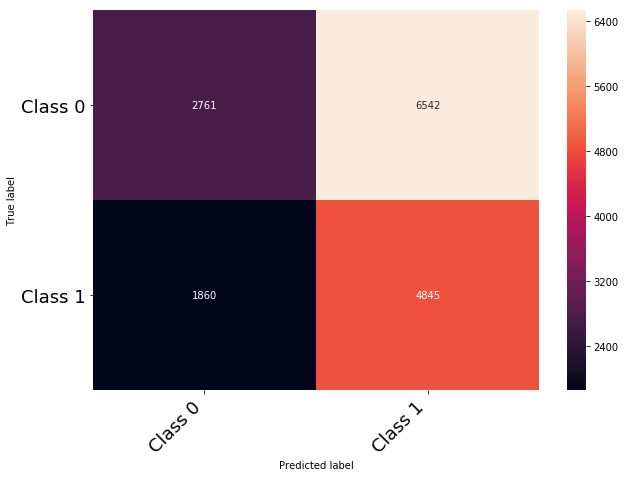

In [473]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

In [496]:
grids['tree'].score(X_train_imputed_scaled, y_train)

0.4498637430068946

In [487]:
grids['tree'].best_score_

0.7405620278725061

## Include language information

In [514]:
filepath = "./data/raw/original/countries.csv"
country = pd.read_csv(filepath)

In [515]:
country

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


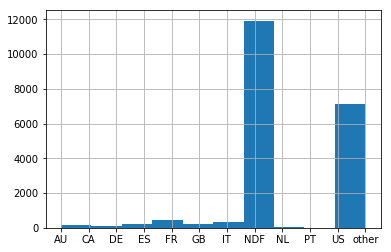

In [532]:
user[user['language'] == 'en']['country_destination'].hist()

In [543]:
sns.distplot(user[user['language'] != 'en']['country_destination'], bin=30)

TypeError: distplot() got an unexpected keyword argument 'bin'

In [544]:
user[user['language'] != 'en']['country_destination']

9155         GB
90725       NDF
127598      NDF
65490        US
18504        NL
90762        US
173640      NDF
11882        US
192294       US
114310      NDF
172069       US
153348      NDF
202722      NDF
37992        ES
73412        US
110634      NDF
148096       US
115488      NDF
79996       NDF
148418      NDF
38769        US
142664      NDF
155599      NDF
95120        US
116322      NDF
125880      NDF
143223      NDF
76962       NDF
99026       NDF
187373      NDF
          ...  
159697      NDF
178249       FR
90988        FR
124918      NDF
101984      NDF
137319      NDF
169891    other
108365      NDF
124132       US
191736      NDF
197487      NDF
134143      NDF
43116        US
52848       NDF
135661       US
149782      NDF
80530     other
150298      NDF
57832       NDF
159467      NDF
148027      NDF
131484      NDF
184376      NDF
77462       NDF
145701      NDF
81424        US
163568       US
190290      NDF
74308       NDF
103653       US
Name: country_destinatio

In [536]:
X_train_dummify.columns

Index(['age', 'signup_flow', 'account_age', 'active_age', 'id_catch_all',
       'gender_-unknown-', 'gender_FEMALE', 'gender_MALE', 'gender_catch_all',
       'signup_method_basic', 'signup_method_facebook',
       'signup_method_catch_all', 'language_en', 'language_catch_all',
       'affiliate_channel_direct', 'affiliate_channel_sem-brand',
       'affiliate_channel_sem-non-brand', 'affiliate_channel_seo',
       'affiliate_channel_other', 'affiliate_channel_api',
       'affiliate_channel_content', 'affiliate_channel_catch_all',
       'affiliate_provider_direct', 'affiliate_provider_google',
       'affiliate_provider_other', 'affiliate_provider_craigslist',
       'affiliate_provider_bing', 'affiliate_provider_facebook',
       'affiliate_provider_catch_all', 'first_affiliate_tracked_untracked',
       'first_affiliate_tracked_linked', 'first_affiliate_tracked_omg',
       'first_affiliate_tracked_catchall',
       'first_affiliate_tracked_tracked-other',
       'first_affiliate_